# **The era of recommander systems**

The rapid growth of data collection has lead to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play. Recommendation Systems are a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or are related to the search history of the user.

They are used to predict the rating or preference that a user would give to an item. Almost every major tech company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, and Facebook uses it to recommend pages to like and people to follow. Moreover, companies like Netflix and Spotify depend highly on the effectiveness of their recommendation engines for their business and sucees.

Two MovieLens datasets are used here. (link : https://www.kaggle.com/rounakbanik/the-movies-dataset/data)

* **The Full Dataset:** Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.
* **The Small Dataset:** Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

We will build our Simple Recommender using movies from the *Full Dataset* whereas all personalized recommender systems will make use of the small dataset (due to the computing power I possess being limited). As a first step, let us build our simple recommender system.

For now let's load the data and import the packages.

In [1]:
#importing required libraries 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import surprise
#conda update --all
#https://pypi.org/project/scikit-surprise/
from surprise import Reader, Dataset, SVD, evaluate


#import implicit

import warnings; warnings.simplefilter('ignore')

In [2]:
m_df = pd.read_csv('movies_metadata.csv')
m_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Understanding the Dataset

The dataset above was obtained through the TMDB API. The movies available in this dataset are in correspondence with the movies that are listed in the **MovieLens Latest Full Dataset** comprising of 26 million ratings on 45,000 movies from 27,000 users. Let us have a look at the features that are available to us.

In [50]:
m_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year', 'cast', 'crew', 'keywords'],
      dtype='object')

### Features

* **adult:** Indicates if the movie is X-Rated or Adult.
* **belongs_to_collection:** A stringified dictionary that gives information on the movie series the particular film belongs to.
* **budget:** The budget of the movie in dollars.
* **genres:** A stringified list of dictionaries that list out all the genres associated with the movie.
* **homepage:** The Official Homepage of the movie.
* **id:** The ID of the move.
* **imdb_id:** The IMDB ID of the movie.
* **original_language:** The language in which the movie was originally shot in.
* **original_title:** The original title of the movie.
* **overview:** A brief blurb of the movie.
* **popularity:** The Popularity Score assigned by TMDB.
* **poster_path:** The URL of the poster image.
* **production_companies:** A stringified list of production companies involved with the making of the movie.
* **production_countries:** A stringified list of countries where the movie was shot/produced in.
* **release_date:** Theatrical Release Date of the movie.
* **revenue:** The total revenue of the movie in dollars.
* **runtime:** The runtime of the movie in minutes.
* **spoken_languages:** A stringified list of spoken languages in the film.
* **status:** The status of the movie (Released, To Be Released, Announced, etc.)
* **tagline:** The tagline of the movie.
* **title:** The Official Title of the movie.
* **video:** Indicates if there is a video present of the movie with TMDB.
* **vote_average:** The average rating of the movie.
* **vote_count:** The number of votes by users, as counted by TMDB.

In [52]:
m_df.shape

(46628, 28)

In [54]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46628 entries, 0 to 46627
Data columns (total 28 columns):
adult                    46628 non-null object
belongs_to_collection    4574 non-null object
budget                   46628 non-null object
genres                   46628 non-null object
homepage                 8009 non-null object
id                       46628 non-null int32
imdb_id                  46611 non-null object
original_language        46617 non-null object
original_title           46628 non-null object
overview                 45633 non-null object
popularity               46624 non-null object
poster_path              46229 non-null object
production_companies     46624 non-null object
production_countries     46624 non-null object
release_date             46540 non-null object
revenue                  46624 non-null float64
runtime                  46360 non-null float64
spoken_languages         46624 non-null object
status                   46542 non-null object

There are a total of **45,466 movies** with **24 features**. Most of the features have very few NaN values (apart from **homepage** and **tagline**). We will attempt at cleaning this dataset to a form suitable for analysis in the next section.

## Data Wrangling

The data that was originally obtained was in the form of a JSON File. This was converted manually into a CSV file to arrive at an input that could be loaded into a Pandas DataFrame effortlessly. In other words, the dataset we have in our hands is already relatively clean. We will however attempt at learning more about our features and performing appropriate wrangling steps to arrive at a form that is more suitable for analysis.

Let us start by removing the features that are not useful to us.

In [55]:
m_df = m_df.drop(['imdb_id'], axis=1)

In [58]:
m_df[m_df['original_title'] != m_df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


The original title refers to the title of the movie in the native language in which the movie was shot. As such, I will prefer using the translated, Anglicized name in this analysis and hence, will drop the original titles altogether. We will be able to deduce if the movie is a foreign language film by looking at the **original_language** feature so no tangible information is lost in doing so.

In [59]:
m_df = m_df.drop('original_title', axis=1)

In [60]:
m_df[m_df['revenue'] == 0].shape

(39087, 26)

We see that the majority of the movies have a recorded revenue of **0**. This indicates that we do not have information about the total revenue for these movies. Although this forms the majority of the movies available to us, we will still use revenue as an extremely important feature going forward from the remaining 7000 movies.

In [61]:
m_df['revenue'] = m_df['revenue'].replace(0, np.nan)

The **budget** feature has some unclean values that makes Pandas assign it as a generic object. We proceed to convert this into a numeric variable and replace all the non-numeric values with NaN. Finally, as with budget, we will convert all the values of 0 with NaN to indicate the absence of information regarding budget.

In [64]:
m_df['budget'] = pd.to_numeric(m_df['budget'], errors='coerce')
m_df['budget'] = m_df['budget'].replace(0, np.nan)
m_df[m_df['budget'].isnull()].shape

(37575, 26)

As we move forward trying to answer certain questions, we will have to construct several features suitable for that particular query. For now, we will construct two very important features:
* **year:** The year in which the movie was released.
* **return:** The ratio of revenue to budget.

The **return** feature is extremely insightful as it will give us a more accurate picture of the financial success of a movie. Presently, our data will not be able to judge if a \$200 million budget movie that earned \$100 million did better than a \$50,000 budget movie taking in \$200,000. This feature will be able to capture that information.

A return value > 1 would indicate profit whereas a return value < 1 would indicate a loss.

In [67]:
m_df['return'] = m_df['revenue'] / m_df['budget']
m_df[m_df['return'].isnull()].shape

(41170, 27)

We have close to **5000 movies** for which we have data on revenue and budget ratio. This is close to **10% of the entire dataset**. Although this may seem small, this is enough to perform very useful analysis and discover interesting insights about the world of movies.

In [11]:
# extracting release year from release_date
m_df['year'] = pd.to_datetime(m_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] 
                                                                           if x != np.nan else np.nan)

In [69]:
m_df['adult'].value_counts()

False    46619
True         9
Name: adult, dtype: int64

There are close to **0 adult movies** in this dataset. The **adult** feature therefore is not of much use to us and can be safely dropped.

In [71]:
m_df = m_df.drop('adult', axis=1)

Let's clarify the column "genres" 

In [6]:
m_df['genres'] = m_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                       if isinstance(x, list) else [])

# Recommendation Systems for movies

There are basically four types of recommender systems:-

> *  **Simple recommander**- They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

> *  **Content Based Filtering**- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

> *  **Collaborative Filtering**- This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

> *  **Hybrid engine**- Here, We brought together ideas from content and collaborative filtering to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.

**Let's start with the first one :**

## Simple Popularity recommendation model

The model simply do implement generalize recommendation to all user based on popularity of movie. The logic behind the model is average audience probably pick or like movies which is critically acclaimed and most popular.This model does not give personalized recommendations based on the user. 

Procedure is as follow.

- First sort movies based on ratings and popularity
- Display the top movies of list. 

** ---- added step ------- ** <br> 
also used genre argument for the top movies of a particular genre. 

   Before getting started with this  -
* we need a metric to score or rate movie 
* Calculate the score for every movie 
* Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes.
So, I'll be using IMDB's weighted rating (wr) which is given as :-

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; 
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**), we just need to calculate C and m :

#### Calculate C

In [8]:
# Calculation of c 
vote_counts = m_df[m_df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = m_df[m_df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

So, the mean rating for all the movies is approximately 5.24 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

#### Calculate m 

In [9]:
## Calculation of m
m = vote_counts.quantile(0.95)
m

434.0

Now, we can filter out the movies that qualify for the chart 

In [12]:
col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']
qualified = m_df[(m_df['vote_count'] >= m) 
                 & (m_df['vote_count'].notnull()) 
                 & (m_df['vote_average'].notnull())][col_list]

# converting vote_count and vote_average colums to integer
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [13]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7,21.9469,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6,17.0155,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7,17.9249,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6,14.686,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7,10.1374,"[Drama, Crime]"
17,Four Rooms,1995,539,6,9.02659,"[Crime, Comedy]"
18,Ace Ventura: When Nature Calls,1995,1128,6,8.20545,"[Crime, Comedy, Adventure]"
31,Twelve Monkeys,1995,2470,7,12.2973,"[Science Fiction, Thriller, Mystery]"
33,Babe,1995,756,6,14.4048,"[Fantasy, Drama, Comedy, Family]"
38,Clueless,1995,828,6,9.88238,"[Comedy, Drama, Romance]"


We see that three Christopher Nolan Films, Inception, The Dark Knight and Interstellar occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors.



Findings as follow:
1. for consideration in the chart, a movie has to have at least **434 votes**. 
2. the average rating for a movie is **5.244** on a scale of 10. 
3. **2274** Movies qualify to be on the chart.

### Calculating weighted ratings and making top 250 chart

As a reminder, here is the formula : ![](https://image.ibb.co/jYWZp9/wr.png)

In [10]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [11]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)

In [12]:
qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)

### Top 10 Movies

In [13]:
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


5 out 10 movies of genres drama. Also three Christopher Nolan Films, **Inception**, **The Dark Knight** and **Interstellar** are part of top 10 list. The list coins a strong bias towards meta data like genres, directors etc. 

Now, building list for particular genres. For that, cutoff is relaxed to **85%** instead of 95. 

In [14]:
temp = m_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
temp.name = 'genre'
mgen_df = m_df.drop('genres', axis=1).join(temp)

In [88]:
def make_toplist(genre, percentile=0.85):
    df = mgen_df[mgen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genre']
    qualified = df[(df['vote_count'] >= m) 
                   & (df['vote_count'].notnull()) 
                   & (df['vote_average'].notnull())][col_list]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['weighted_rating'] = qualified.apply(lambda x: 
                                                   (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), 
                                                   axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
    return qualified

#### Top 10 Animation Movies

In [18]:
make_toplist('Animation').head(10)

,title,year,vote_count,vote_average,popularity,genre,weighted_rating
359,The Lion King,1994,5520,8,21.6058,Animation,7.909339
5481,Spirited Away,2001,3968,8,41.0489,Animation,7.875933
9698,Howl's Moving Castle,2004,2049,8,16.136,Animation,7.772103
2884,Princess Mononoke,1997,2041,8,17.1667,Animation,7.771305
5833,My Neighbor Totoro,1988,1730,8,13.5073,Animation,7.735274
40251,Your Name.,2016,1030,8,34.461252,Animation,7.589820
5553,Grave of the Fireflies,1988,974,8,0.010902,Animation,7.570962
19901,Paperman,2012,734,8,7.19863,Animation,7.465676
39386,Piper,2016,487,8,11.243161,Animation,7.285132
20779,Wolf Children,2012,483,8,10.2495,Animation,7.281198


#### Of course The Lion King is at the first place, how could it not be ? :D

### Top 10 Romance Movies

In [49]:
make_toplist('Romance').head(10)

,title,year,vote_count,vote_average,popularity,genre,weighted_rating
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,Romance,8.565285
351,Forrest Gump,1994,8147,8,48.3072,Romance,7.971357
876,Vertigo,1958,1162,8,18.2082,Romance,7.811667
40251,Your Name.,2016,1030,8,34.461252,Romance,7.789489
883,Some Like It Hot,1959,835,8,11.8451,Romance,7.745154
1132,Cinema Paradiso,1988,834,8,14.177,Romance,7.744878
19901,Paperman,2012,734,8,7.19863,Romance,7.713951
37863,Sing Street,2016,669,8,10.672862,Romance,7.689483
882,The Apartment,1960,498,8,11.9943,Romance,7.599317
38718,The Handmaiden,2016,453,8,16.727405,Romance,7.566166


The top romance movie here according to our metrics is Bollywood's Dilwale Dulhania Le Jayenge.

Now let's see if we can build list by year. For that, cutoff is alsorelaxed to 85% instead of 95.

In [ ]:
year1 = m_df.apply(lambda x: pd.Series(x['year']),axis=1).stack().reset_index(level=1, drop=True)
year1.name = 'year'
myear_df = m_df.drop('year', axis=1).join(year1)

In [ ]:
def make_toplist(year1, percentile=0.85):
    df = myear_df[myear_df['year'] == year1]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity']
    qualified = df[(df['vote_count'] >= m) 
                   & (df['vote_count'].notnull()) 
                   & (df['vote_average'].notnull())][col_list]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['weighted_rating'] = qualified.apply(lambda x: 
                                                   (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), 
                                                   axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
    return qualified

### Top 10 2010 movies

In [111]:
make_toplist('2010').head(10)

,title,year,vote_count,vote_average,popularity,weighted_rating
15651,Inception,2010,14075,8,29.1081,7.977087
17064,Senna,2010,282,8,11.3319,7.193455
15643,Despicable Me,2010,6595,7,22.2745,6.969629
14997,Shutter Island,2010,6559,7,15.8136,6.969466
16305,Harry Potter and the Deathly Hallows: Part 1,2010,5708,7,23.3004,6.965008
15189,Kick-Ass,2010,4747,7,17.2604,6.958100
15519,Toy Story 3,2010,4710,7,16.9665,6.957780
16243,Black Swan,2010,4562,7,12.9891,6.956445
15156,How to Train Your Dragon,2010,4319,7,14.4167,6.954062
15975,The Social Network,2010,3492,7,16.973,6.943548


# **Content Based Filtering**

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

** Limitation of Popularity model ** <br>

A major drawback of this algorithm is that it is limited to recommending items that are of the same type. It will never recommend products which the user has not bought or liked in the past. So if a user has watched or liked only action movies in the past, the system will recommend only action movies. It’s a very narrow way of building an engine.

Therefore, let's build a model that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. For that we have to consider metadata (or content), hence, it also known as **Content Based Filtering.**

Two Content Based Recommendation is implemented based on different contents:
1. Description Based (content: Movie Overviews and Taglines)
2. Meta Data Based (content : Movie Cast, Crew, Keywords and Genre)

** Note **: A small movie data set is used due to limiting computing power available to me. 

In [14]:
small_mdf = pd.read_csv('links_small.csv')
small_mdf = small_mdf[small_mdf['tmdbId'].notnull()]['tmdbId'].astype('int')

Before extracting small data set, we need to make sure that the ID column of our main dataframe is clean and of type integer. To do this, let us try to perform an integer conversion of our IDs and if an exception is raised,we will replace the ID with NaN. We will then proceed to drop these rows from our dataframe.

In [22]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [23]:
m_df['id'] = m_df['id'].apply(convert_int)

In [24]:
m_df[m_df['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,Avalanche Sharks,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [25]:
m_df = m_df.drop([19730, 29503, 35587])
m_df['id'] = m_df['id'].astype('int')

In [26]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df.shape

(9099, 25)

**9099** movies avaiable in our small movies metadata dataset

### 1. Description Based Recommendation

In [10]:
sm_df['tagline'] = sm_df['tagline'].fillna('')
sm_df['description'] = sm_df['overview'] + sm_df['tagline']
sm_df['description'] = sm_df['description'].fillna('')

#### Compute TF-IDF matrix 

For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview.
Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as 
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each column represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it? 

In [11]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(sm_df['description'])
tfidf_matrix.shape

(9099, 268124)

We see that over 260,000 different words were used to describe our movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
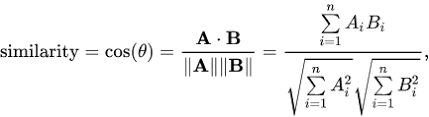

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [12]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [13]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We are going to define a function that takes in a movie title as an input and outputs a list of the 50 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [14]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
indices = pd.Series(sm_df.index, index=sm_df['title'])

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [15]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 50 most similar movies
    sim_scores = sim_scores[1:51]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 50 most similar movies
    return titles.iloc[movie_indices]

Let us now try and get the top 10 recommendations for a few movies.

In [16]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [39]:
get_recommendations('The Lion King').head(10)

5870    The Lion King 2: Simba's Pride
514                              Andre
371                       Black Beauty
7775                      African Cats
6645                     Becoming Jane
8921                   The Jungle Book
4519                         Born Free
8619          The Hundred-Foot Journey
2566                          Papillon
3978                  The Time Machine
Name: title, dtype: object

In [40]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

We see that for **The Dark Knight**, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked **The Dark Knight** probably likes it more because of Nolan and would hate **Batman Forever** and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than **Overview** and **Tagline**. In the next subsection, Let's build a more sophisticated recommender that takes **genre**, **keywords**, **cast** and **crew** into consideration.

### 2.  Metadata Based Recommendation

In [16]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [27]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
m_df['id'] = m_df['id'].astype('int')
m_df.shape

(45463, 25)

In [28]:
# merging require details with our main dataframe 
m_df = m_df.merge(credits, on='id')
m_df = m_df.merge(keywords, on='id')

In [29]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df.shape

(9219, 28)

In [21]:
sm_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. **Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the *feel* of the movie.
2. **Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list. 

In [30]:
sm_df['cast'] = sm_df['cast'].apply(literal_eval)
sm_df['crew'] = sm_df['crew'].apply(literal_eval)
sm_df['keywords'] = sm_df['keywords'].apply(literal_eval)
sm_df['cast_size'] = sm_df['cast'].apply(lambda x: len(x))
sm_df['crew_size'] = sm_df['crew'].apply(lambda x: len(x))

In [23]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [24]:
sm_df['director'] = sm_df['crew'].apply(get_director)

In [25]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
sm_df['cast'] = sm_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [26]:
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

The approach to building the recommendation is going to be extremely *hacky*. The plan on doing is creating a metadata dump for every movie which consists of **genres, director, main actors and keywords.** I then use a **Count Vectorizer** to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of genres and credits data:
1. **Strip Spaces and Convert to Lowercase** from all our features. This way, engine will not confuse between **Johnny Depp** and **Johnny Galecki.** 
2. **Mention Director 2 times** to give it more weight relative to the entire cast.

In [30]:
sm_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter]"
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,"[joejohnston, joejohnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,"[howarddeutch, howarddeutch]"
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,"[forestwhitaker, forestwhitaker]"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,"[charlesshyer, charlesshyer]"


In [27]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [28]:
sm_df['director'] = sm_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
sm_df['director'] = sm_df['director'].apply(lambda x: [x,x])

#### Keywords

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequence counts of every keyword that appears in the dataset.

In [29]:
keyword_occurences = sm_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
keyword_occurences.name = 'keyword'

In [30]:
keyword_occurences = keyword_occurences.value_counts()
keyword_occurences[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as Dogs and Dog are considered the same.

In [31]:
keyword_occurences = keyword_occurences[keyword_occurences > 1]

In [32]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [33]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in keyword_occurences:
            words.append(i)
    return words

In [34]:
sm_df['keywords'] = sm_df['keywords'].apply(filter_keywords)
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [47]:
sm_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter]"
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,"[howarddeutch, howarddeutch]"
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,"[forestwhitaker, forestwhitaker]"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,"[charlesshyer, charlesshyer]"


We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [35]:
sm_df['soup'] = sm_df['keywords'] + sm_df['cast'] + sm_df['director'] + sm_df['genres']
sm_df['soup'] = sm_df['soup'].apply(lambda x: ' '.join(x))

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [37]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(sm_df['soup'])

In [39]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [40]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
indices = pd.Series(sm_df.index, index=sm_df['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for **The Dark Knight** again and see what recommendations I get this time around.

In [42]:
get_recommendations('The Dark Knight').head(10)

173                        Species
3379                   Exit Wounds
6842    Far from the Madding Crowd
12                           Balto
6427                Curious George
6568                 Blithe Spirit
3635                The Dream Team
9066        Long-Term Relationship
1611            The Black Cauldron
2167        The General's Daughter
Name: title, dtype: object

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

In [73]:
get_recommendations('The Lion King').head(10)

5870              Suburbia
514                  Andre
371           Black Beauty
7775             Burlesque
6645           Harsh Times
8921                Ismael
4519    Permanent Vacation
8619         Cheap Thrills
2566      Any Given Sunday
3978            Crossroads
Name: title, dtype: object

#### Popularity and Ratings

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. 

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 50 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of $m$, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [74]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sm_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [75]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
6623,The Prestige,4510,8,2006,7.758148
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
524,Batman,2145,7,1989,6.704647
1031,M,465,8,1931,6.669950
7659,Batman: Under the Red Hood,459,7,2010,6.147016
2085,Following,363,7,1998,6.044272
1134,Batman Returns,1706,6,1992,5.846862
4145,Insomnia,1181,6,2002,5.797081


In [76]:
improved_recommendations('The Lion King')

,title,vote_count,vote_average,year,wr
9205,Piper,487,8,2016,6.701721
8389,Wolf Children,483,8,2012,6.696058
2166,Tarzan,1715,7,1999,6.645549
855,The Fox and the Hound,884,7,1981,6.422068
12,Balto,423,7,1995,6.111185
5991,The Cat Returns,364,7,2002,6.045470
5935,Whisper of the Heart,349,7,1995,6.027184
8289,From Up on Poppy Hill,332,7,2011,6.005594
6205,Madagascar,3322,6,2005,5.912749
1597,Bambi,1450,6,1942,5.826054


## Collaborative Filtering


Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

** Limitation of content based recommendation**: 
- It is only capable of suggesting movies which are *close* to a certain movie. That is, it is not capable of capturing interest and providing recommendations across genres.

- It doesn't capture the personal interest and biases of a user. Anyone querying on model for recommendations based on a movie will receive the same recommendations for that movie, regardless of who he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

We will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [79]:
reader = Reader()

In [80]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [81]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [83]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8878
MAE:  0.6827
------------
Fold 2
RMSE: 0.9034
MAE:  0.6945
------------
Fold 3
RMSE: 0.8988
MAE:  0.6942
------------
Fold 4
RMSE: 0.8962
MAE:  0.6910
------------
Fold 5
RMSE: 0.9008
MAE:  0.6921
------------
------------
Mean RMSE: 0.8974
Mean MAE : 0.6909
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.887758347237658,
                             0.9034111570555344,
                             0.8987770659198613,
                             0.8962350860477564,
                             0.900802059608535],
                            'mae': [0.6827447575541966,
                             0.6944601244688939,
                             0.6942264290501537,
                             0.6909780189445316,
                             0.6920609535523705]})

We get a mean **Root Mean Square Error** of 0.8965 which is more than good enough right now. Let us now train on dataset and arrive at predictions.

In [95]:
trainset = data.build_full_trainset()
svd.train(trainset)

Let us pick user 1 and check the ratings he has given.

In [86]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [96]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.636858681966543, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of **2.636**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender

we build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [32]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [39]:

id_map = id_map.merge(sm_df[['title', 'id']], on='id').set_index('title')

In [40]:
id_map.head()

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0


In [41]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(sm_df[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [101]:
indices_map = id_map.set_index('id')

In [46]:
 tmdbId = id_map.loc["Jumanji"]['id']
print(tmdbId)

8844.0


In [103]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sm_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [105]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.175845
1011,The Terminator,4208.0,7.4,1984,218,3.157167
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.068006
974,Aliens,3282.0,7.7,1986,679,3.023540
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.999218
7705,Alice in Wonderland,8.0,5.4,1933,25694,2.903407
2014,Fantastic Planet,140.0,7.6,1973,16306,2.862936
4017,Hawk the Slayer,13.0,4.5,1980,25628,2.854457
2834,Predator,2129.0,7.3,1987,106,2.833494
8865,Star Wars: The Force Awakens,7993.0,7.5,2015,140607,2.782960


In [106]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
7705,Alice in Wonderland,8.0,5.4,1933,25694,3.409063
1668,Return from Witch Mountain,38.0,5.6,1978,14822,3.313618
2132,Superman II,642.0,6.5,1980,8536,3.178889
8724,Jupiter Ascending,2816.0,5.2,2015,76757,3.150460
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.143644
2834,Predator,2129.0,7.3,1987,106,3.102033
3060,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,3.085938
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.082938
1621,Darby O'Gill and the Little People,35.0,6.7,1959,18887,3.031035
2014,Fantastic Planet,140.0,7.6,1973,16306,3.029242


In [107]:
hybrid(500, 'Predator')

,title,vote_count,vote_average,year,id,est
6252,Serenity,1287.0,7.4,2005,16320,3.356357
8869,Ant-Man,6029.0,7.0,2015,102899,3.285809
8854,Terminator Genisys,3677.0,5.8,2015,87101,3.127159
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.082938
5931,Darkman II: The Return of Durant,44.0,4.5,1995,18998,3.070587
7208,Replicant,93.0,5.0,2001,10596,2.992363
1298,The Hunt for Red October,971.0,7.2,1990,1669,2.980674
1117,Star Trek: First Contact,671.0,7.0,1996,199,2.914454
4966,Hercules in New York,63.0,3.7,1969,5227,2.764290
8689,Transformers: Age of Extinction,3136.0,5.8,2014,91314,2.721820


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

## Conclusion

In this notebook, we have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender:** This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
2. **Content Based Recommender:** We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
3. **Collaborative Filtering:** We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.
4. **Hybrid Engine:** We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.

Up to this point we have learnt what is a recommendation engine, its different types and their workings. Both content-based filtering and collaborative filtering algorithms have their strengths and weaknesses.

In some domains, generating a useful description of the content can be very difficult. A content-based filtering model will not select items if the user’s previous behavior does not provide evidence for this. Additional techniques have to be used so that the system can make suggestions outside the scope of what the user has already shown an interest in.

A collaborative filtering model doesn’t have these shortcomings. Because there is no need for a description of the items being recommended, the system can deal with any kind of information. Furthermore, it can recommend products which the user has not shown an interest in previously. But, collaborative filtering cannot provide recommendations for new items if there are no user ratings upon which to base a prediction. Even if users start rating the item, it will take some time before the item has received enough ratings in order to make accurate recommendations.

A system that combines content-based filtering and collaborative filtering could potentially take advantage from both the representation of the content as well as the similarities among users. One approach to combine collaborative and content-based filtering is to make predictions based on a weighted average of the content-based recommendations and the collaborative recommendations. Like the Hybrid Engine we did earlier.

There are many different ways to set up a recommender system and just like other machine learning algorithms it is very important to know which objective has to be optimized and therefore which layout should be choosen.<br>

**Here you can find more in-depth content: [Pinterest](https://www.pinterest.de/dataliftoff/recommender-systems/)***


Other **python recommender libraries** are:
+ [implicit](https://github.com/benfred/implicit)
+ [spotlight](https://github.com/maciejkula/spotlight)
+ [turicreate](https://github.com/apple/turicreate/blob/master/README.md)
+ [mrec](https://github.com/Mendeley/mrec)
+ [recsys](https://github.com/ocelma/python-recsys)
+ [crab](http://muricoca.github.io/crab/)


[Blog](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/)